In [2]:
pip install CatBoost

     |████████████████████████████████| 65.7MB 61kB/s 


In [3]:
import numpy as np
from scipy.optimize import differential_evolution
from scipy.special import expit
from sklearn.metrics import roc_auc_score
import pandas as pd
import math
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torchvision import datasets, transforms

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
class Net(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_features, 1) / math.sqrt(num_features))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, xb):
        return xb @ self.weights + self.bias



def f(b):
    round_b = torch.round(torch.clamp(b, 0))
    print((X < round_b[None, :]).all(axis=1).int())
    return (((X < round_b[None, :]).all(axis=1).int() - y) ** 2).sum()

def lax(optimized_f, num_features, mean_val_feat=0, alpha1=0.1, alpha2=0.1):
    pred_f = 1e10
    mu = torch.zeros(num_features) + mean_val_feat
    log_sigma = torch.ones(num_features)
    model = Net(num_features)
    while True:

        eps = torch.normal(torch.zeros(num_features), torch.ones(num_features))
        b = mu + eps * torch.exp(log_sigma)
        b.requires_grad_()
        pred = model.forward(b)

        pred.backward(retain_graph=True)
        step_mu = (optimized_f(b) - pred) * (b - mu) / (torch.exp(log_sigma) ** 2 + 1e-8) + b.grad 
        step_sigma = (optimized_f(b) - pred)  * ((b - mu)** 2 / (torch.exp(log_sigma) ** 2 + 1e-8) - 1) + b.grad * eps * torch.exp(log_sigma)
        g_theta = step_mu.sum() + step_sigma.sum()
        g_theta.backward()
        
        with torch.no_grad():
            log_sigma -= alpha1 * step_sigma * torch.exp(log_sigma)
            mu -= alpha1 * step_mu
            model.weights -= 2 * g_theta * model.weights.grad
            model.bias -= 2 * g_theta * model.bias.grad


            model.weights.zero_()
            model.bias.zero_()
            if optimized_f(b) <= pred_f and pred_f - optimized_f(b) < 0.1:

                break
            pred_f = optimized_f(b)


    return torch.round(torch.clamp(b, 0))


In [36]:
class Boosting_Elcl:
    def __init__(self, tol=0.4, max_iter=100, inv_feat=0, feature_subset=0.7):
        self.tol = tol
        self.max_iter = max_iter
        self.inv_feat = inv_feat
        self.feature_subset = feature_subset
        self.method = "lax"
        pass
    def fit(self, X_train, y_train, max_elems, **kwargs):
        self.max_elems = max_elems
        self.trees = []            
        self.sigmas = []
        target = y_train.copy()
        # меняем обозначение класса с 0 на -1
        target[target == 0] = -1
        y_train[y_train == 0] = -1
        #границы для y1, y2
        A = 10/self.max_iter
        bounds = [(-A, A), (-A, A)]
        #границы для значений сигма
        #bounds.extend([(0, 3 * i) for i in max_elems])
        
        ans = np.zeros(X_train.shape[0])
        ttarget = target.copy()
        tans = ans.copy()

        def optimized_f_for_evolution(x):
            y2, y1, sigma = x[0], x[1], x[2:]
            tmp_res = np.all(new_X_train <= sigma[None, :], axis=1)
            tmp_ans = np.zeros(tmp_res.shape)
            tmp_ans[tmp_res == True] = y1
            tmp_ans[tmp_res == False] = y2 
            return np.sum((tmp_ans - target) ** 2)


        for _ in range(self.max_iter):
            new_X_train = X_train.copy()
            feature_idx = np.arange(X_train.shape[1])
            if self.feature_subset != 1:
                
                tmp = int((X_train.shape[1] - self.inv_feat) * self.feature_subset)
                feature_idx = np.sort(np.random.choice(X_train.shape[1] - self.inv_feat, tmp, 
                                                       replace=False))
                tmp_max_elems = max_elems[feature_idx]
                
                feature_idx = np.append(feature_idx, feature_idx + X_train.shape[1] - self.inv_feat)
                feature_idx = feature_idx[feature_idx < new_X_train.shape[1]]
                new_X_train = new_X_train[:, feature_idx]


            #Подбор нового эл.кл.
            if self.method == "diff_evolution":
                bounds = [(-A, A), (-A, A)]
                bounds.extend([(0, 10 * i) for i in max_elems[feature_idx]])
                tmp = differential_evolution(optimized_f_for_evolution,  bounds, popsize=15, **kwargs).x

                sigma = max_elems.copy()
                sigma[feature_idx] = tmp[2:]
                self.sigmas.append((tmp[0], tmp[1], sigma))

            elif self.method == "lax":
                def optimized_f_for_lax(sigma):
                    tmp_res = (torch.from_numpy(new_X_train) <= sigma[None, :]).all(axis=1)
                    tmp_ans = torch.zeros(tmp_res.shape)
                    tmp_ans[tmp_res == True] = 1
                    tmp_ans[tmp_res == False] = 0
                    return ((tmp_ans - target) ** 2).mean()
                sigma = max_elems.copy()
                sigma[feature_idx] = lax(optimized_f_for_lax, new_X_train.shape[1], new_X_train.max() // 2).detach().numpy()
                self.sigmas.append((0, 1, sigma))

            #Получение предсказания композиции уже подобранных эл.кл.
            res = np.all(X_train <= sigma[None, :], axis=1)
            ans[res == True] += self.sigmas[-1][1]
            ans[res == False] += self.sigmas[-1][0]
            prob = expit(ans)
            loss = np.mean(np.logaddexp(0, -y_train * ans))
            
            if loss < self.tol:
                break
            
            #Вычисление нового target
            target = y_train * expit(-y_train * ans)
            #print(target)
            #print(np.round(target, 4))
            
            tree = DecisionTreeRegressor(max_depth=1)
            tree.fit(X_train, ttarget)
            self.trees.append(tree)
            tans += tree.predict(X_train)
            ttarget = y_train * expit(-y_train * tans)

            #print("elcl ", loss, " tree ", np.mean(np.logaddexp(0, -y_train * tans)))
            #print(np.sum((np.logaddexp(0, -y_train * tans) - np.logaddexp(0, -y_train * ans))** 2)**0.5)
        y_train[y_train == -1] = 0

    def predict(self, X_test):
        ans = np.zeros(X_test.shape[0])
        tans = ans.copy()
        for y2, y1, sigma in self.sigmas:
            res = np.all(X_test <= sigma[None, :], axis=1)
            ans[res == True] += y1
            ans[res == False] += y2
            
        
        #Вероятность класса 1
        proba = expit(ans)[:, np.newaxis]
        #np.hstack((proba, 1 - proba))
        
        # Получаем метки
        tmp = np.sign(ans)
        tmp[tmp == -1] = 0
        tmp = tmp.astype(np.int)

        for tree in self.trees:
            tans += tree.predict(X_test)
        
        return expit(ans)[:, np.newaxis] #proba
        

In [8]:
class One_vs_all:
    def __init__(self, tol=0.4, max_iter=100, inv_feat=0):
        self.tol = tol
        self.max_iter = max_iter
        self.inv_feat = inv_feat

    def fit(self, X, y, max_elems, **kwargs):
        self.classes = np.unique(y)
        self.models = []

        if len(self.classes) == 2:
            tmp_model = Boosting_Elcl(tol=self.tol, max_iter=self.max_iter, inv_feat=self.inv_feat)
            y_tmp = y.copy()
            y_tmp[y == 1] = 1
            y_tmp[y != 1] = -1
            tmp_model.fit(X, y_tmp, max_elems, **kwargs)
            self.models.append(tmp_model)
            return
        
        for k in self.classes:
            tmp_model = Boosting_Elcl(tol=self.tol, max_iter=self.max_iter, inv_feat=self.inv_feat)
            y_tmp = y.copy()
            y_tmp[y == k] = 1
            y_tmp[y != k] = -1
            tmp_model.fit(X, y_tmp, max_elems, **kwargs)
            self.models.append(tmp_model)
            
    def predict(self, X):
        res = np.zeros((X.shape[0], len(self.classes)))

        if len(self.classes) == 2:
            res[:, 1] = self.models[0].predict(X)[:, 0]
            res[:, 0] = 1 - res[:, 1]

        else:
            for k, model in enumerate(self.models):
                res[:, k] = model.predict(X)[:, 0]
        #print(res)
        return np.argmax(res, axis=1)
            

In [9]:
def my_cv(X, y, tol, num_runs, inv_feat, cv = 3, **kwargs):
    ans = np.zeros((X.shape[0]))
    ind = np.random.shuffle(np.arange(X.shape[0]))
    for i in range(cv):
        a, b = (X.shape[0] // cv) * i, (X.shape[0] // cv) * (i + 1)
        m = One_vs_all(tol=tol, max_iter=num_runs, inv_feat=inv_feat)
        m.fit(np.vstack((X[:a], X[b:])), np.append(y[:a], y[b:]), np.max(X, axis=0), **kwargs)
        ans[a:b] = m.predict(X[a:b])
    
    return ans

In [10]:
def enc(X, thr):
    newX = X.copy()
    inv = X.shape[1] - 1
    c = 0
    for i in range(X.shape[1]):
        encode = {k:j for j, k in enumerate(sorted(np.unique(X[:, i])))}
        if max(encode.values()) < thr:
            new_i = inv
            inv -= 1
        else:
            new_i = c
            c += 1
        for j in range(X.shape[0]):
            newX[j, new_i] = encode[X[j, i]]

    return newX, c

In [11]:
def add_inverse(X, size):
    #a = np.arange(X.shape[1])
    #ind = np.random.choice(a, size=size, replace=False)
    ind = np.arange(size)
    newX = np.zeros((X.shape[0], X.shape[1] + len(ind)), dtype=np.int)
    newX[:, : X.shape[1]] = X
    for j, i in enumerate(ind):
        newX[:, X.shape[1] + j] = np.max(X[:, i]) - X[:, i]
    return newX

In [12]:

def ohe(target, classes):
    return (classes == target[:, None]).astype(int)

In [13]:
def get_rocauc(Xd, X, y, n_estimators, inv_feat, cv=3, **kwargs):

    ans = my_cv(Xd, y, tol=0.1, num_runs=n_estimators, inv_feat=inv_feat, cv=cv, **kwargs)

    lgbm = lgb.LGBMClassifier(n_estimators=n_estimators)
    ans_lgbm = cross_val_predict(lgbm, X, y, cv=cv)

    xgbm = xgb.XGBClassifier(n_estimators=n_estimators)
    ans_xgbm = cross_val_predict(xgbm, X, y, cv=cv)

    cb = CatBoostClassifier(iterations=n_estimators, verbose=False)
    ans_cb = cross_val_predict(cb, X, y, cv=cv)

    classes = np.arange(len(np.unique(y)))
    tmp = ohe(y, classes)

    return [roc_auc_score(tmp, ohe(ans, classes), average='macro'), roc_auc_score(tmp, ohe(ans_lgbm, classes), average='macro'),
            roc_auc_score(tmp, ohe(ans_xgbm, classes), average='macro'), roc_auc_score(tmp, ohe(ans_cb.reshape(-1, ), classes), average='macro')]

In [14]:
def get_rocauc_hist(X, y, n_estimators, cv=3, **kwargs):

    lgbm = lgb.LGBMClassifier(n_estimators=n_estimators)
    ans_lgbm = cross_val_predict(lgbm, X, y, cv=cv)

    xgbm = xgb.XGBClassifier(n_estimators=n_estimators)
    ans_xgbm = cross_val_predict(xgbm, X, y, cv=cv)

    cb = CatBoostClassifier(iterations=n_estimators, verbose=False)
    ans_cb = cross_val_predict(cb, X, y, cv=cv)

    classes = np.arange(len(np.unique(y)))
    tmp = ohe(y, classes)

    return [roc_auc_score(tmp, ohe(ans_lgbm, classes), average='macro'),
            roc_auc_score(tmp, ohe(ans_xgbm, classes), average='macro'), roc_auc_score(tmp, ohe(ans_cb.reshape(-1, ), classes), average='macro')]

In [15]:
data_ph = pd.read_csv('/content/drive/My Drive/datasets_81236_188723_ph-data.csv')
X = data_ph.drop(columns=['label']).values.astype(int)
y = data_ph[['label']].values[:, 0]

In [16]:
X1, c = enc(X, thr=3)
Xd = add_inverse(X1, c)
feature_subset = 0.8
cv = 3
feature_subset = 1
'm = ' + str(math.ceil(Xd.shape[0]*(cv-1)/cv)), 'k = ' + str(np.max(Xd) + 1),\
'n = ' + str(int(Xd.shape[1] * feature_subset))

('m = 436', 'k = 186', 'n = 6')

In [39]:
get_rocauc(Xd, X, y, 10, c)

[0.50528522447606, 0.8331951273050112, 0.8399146920789616, 0.8318290509207212]

In [40]:
classes = np.arange(len(np.unique(y)))
tmp = ohe(y, classes)

roc_auc_score(tmp, ohe(ans, classes), average='macro')

NameError: ignored

In [ ]:
m = One_vs_all(max_iter=20)
m.fit(Xd, y, np.max(Xd, axis=0))
ans = m.predict(Xd)

In [ ]:
iter = [10, 20, 30, 40, 50]
res = []
for i in iter:
    res.append(get_rocauc(Xd, X, y, i, c))

Text(0.5, 1.0, 'cross validation ROC-AUC, ph-dataset')

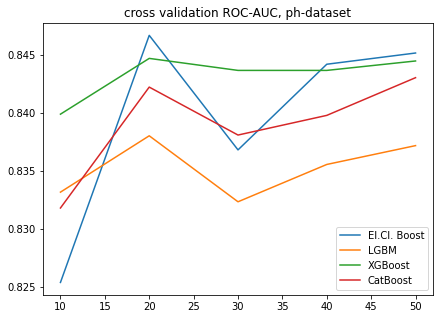

In [ ]:
#fig, ax = plt.subplots(4, 1)
plt.figure(figsize=(7, 5))
name = ["El.Cl. Boost", "LGBM", "XGBoost", "CatBoost"]
for i in range(4):
    t = []
    for elem in res:
        t.append(elem[i])
    plt.plot(iter, t, label=name[i])
plt.legend()
plt.title("cross validation ROC-AUC, ph-dataset")
#plt.savefig("ph-inv.pdf")

In [ ]:
data_heart = pd.read_csv('/content/drive/My Drive/datasets_33180_43520_heart.csv')

X = data_heart.drop(columns=['target']).values.astype(int)
y = data_heart[['target']].values[:, 0]

X.shape, np.max(X)

((303, 13), 564)

In [ ]:
X1, c = enc(X, thr=3)

inv_feat = c
Xd = add_inverse(X1, c)
cv = 3
feature_subset = 0.8


In [ ]:
get_rocauc(Xd, X, y, 70, c, cv=5)

[0.7206192358366272,
 0.8185770750988142,
 0.8022397891963109,
 0.8464426877470356]

In [ ]:
iter = [10, 30, 50, 70, 100]
res = []
for i in iter:
    res.append(get_rocauc(Xd, X, y, i, c, cv=5))

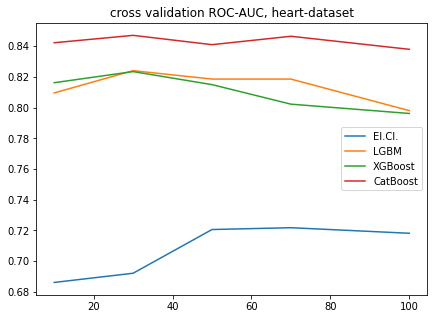

In [ ]:

#fig, ax = plt.subplots(4, 1)
plt.figure(figsize=(7, 5))
name = ["El.Cl.", "LGBM", "XGBoost", "CatBoost"]
for i in range(4):
    t = []
    for elem in res:
        t.append(elem[i])
    plt.plot(iter, t, label=name[i])
plt.legend()
plt.title("cross validation ROC-AUC, heart-dataset")
plt.savefig("heart-inv.pdf")

In [ ]:
get_rocauc(Xd, X, y, 200, c)

[0.5814888010540185, 0.8234519104084321, 0.814361001317523]

In [ ]:
#m = One_vs_all(max_iter=20)
ans=my_cv(Xd, y, tol=0.1, num_runs=15, strategy='best1exp',
                                          mutation=(1.2, 1.5), recombination=0.8, maxiter=5)
#ans = m.predict(Xd)

In [ ]:
classes = np.arange(len(np.unique(y)))
tmp = ohe(y, classes)

roc_auc_score(tmp, ohe(ans, classes), average='macro')

0.5005270092226615

In [ ]:
data_dermatology = pd.read_csv('/content/drive/My Drive/dermatology.csv')

X = data_dermatology.drop(columns=['class']).values.astype(int)
y = data_dermatology[['class']].values[:, 0] - 1

In [ ]:
X1, c = enc(X, thr=3)
inv_feat = 0
Xd = add_inverse(X1, c)
cv = 3
feature_subset = 0.6
'm = ' + str(math.ceil(Xd.shape[0]*(cv-1)/cv)), 'k = ' + str(np.max(Xd)+ 1),\
'n = ' + str(int(Xd.shape[1] * feature_subset ))

('m = 244', 'k = 61', 'n = 39')

In [ ]:
get_rocauc(Xd, X, y, 2, c)

KeyboardInterrupt: ignored

In [ ]:
iter = [5, 10, 15, 20]
res = []
for i in iter:
    res.append(get_rocauc(Xd, X, y, i, c))

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(7, 5))
name = ["El.Cl.", "LGBM", "XGBoost", "CatBoost"]
for i in range(4):
    t = []
    for elem in res:
        t.append(elem[i])
    plt.plot(iter, t, label=name[i])
plt.legend()
plt.title("cross validation ROC-AUC, dermatology-dataset")
plt.savefig("dermatology-inv.pdf")

In [ ]:
m = One_vs_all(max_iter=10)
m.fit(Xd, y, np.max(Xd, axis=0))
ans = m.predict(Xd)

[[0.08659356 0.31818392 0.08327144 0.1892685  0.08378917 0.08398458]
 [0.91425614 0.13160769 0.08327144 0.13130779 0.08378917 0.08398458]
 [0.08659356 0.22874947 0.91552727 0.26089711 0.08378917 0.08398458]
 ...
 [0.08659356 0.09908876 0.91552727 0.14801616 0.08378917 0.08398458]
 [0.08659356 0.07215011 0.91552727 0.17176207 0.08378917 0.08398458]
 [0.91425614 0.1925442  0.08327144 0.10909743 0.08378917 0.08398458]]


In [ ]:
classes = np.arange(len(np.unique(y)))
tmp = ohe(y, classes)

roc_auc_score(tmp, ohe(ans, classes), average='macro')

0.9801540333785836

In [ ]:
data_car = pd.read_csv('/content/drive/My Drive/car.data', header=None)
data_car = data_car.replace('low', 0)
data_car = data_car.replace('med', 1)
data_car = data_car.replace('high', 2)
data_car = data_car.replace('vhigh', 3)

data_car = data_car.replace('5more', 5)
data_car = data_car.replace('more', 5)

data_car = data_car.replace('small', 0)
data_car = data_car.replace('big', 2)

data_car = data_car.replace('unacc', 0)
data_car = data_car.replace('acc', 1)
data_car = data_car.replace('good', 2)
data_car = data_car.replace('vgood', 3)

In [ ]:
X = data_car.values[:, :6].astype(int)
y = data_car[6].values

In [ ]:
X1, c = enc(X, thr=3)
Xd = add_inverse(X1, c)
#Xd = X1
cv = 3
feature_subset = 1
'm = ' + str(math.ceil(Xd.shape[0]*(cv-1)/cv)), 'k = ' + str(np.max(Xd) + 1),\
'n = ' + str(int(Xd.shape[1] * feature_subset ))

('m = 1152', 'k = 4', 'n = 9')

In [ ]:
X1.shape, c

((1728, 6), 3)

In [ ]:
get_rocauc(Xd, X, y, 40, c, cv=5)

[0.6514588909120158,
 0.8184679955870813,
 0.7144089707054504,
 0.8598738218862682]

In [ ]:
iter = [25, 50, 75, 100, 125]
res = []
for i in iter:
    res.append(get_rocauc(Xd, X, y, i, c))

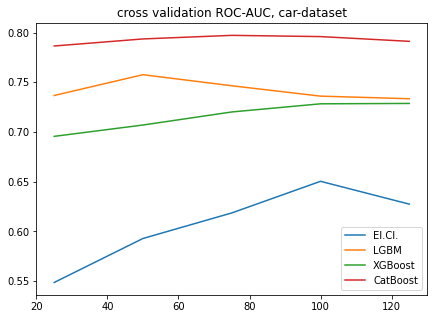

In [ ]:
#fig, ax = plt.subplots(4, 1)
plt.figure(figsize=(7, 5))
name = ["El.Cl.", "LGBM", "XGBoost", "CatBoost"]
for i in range(4):
    t = []
    for elem in res:
        t.append(elem[i])
    plt.plot(iter, t, label=name[i])
plt.legend()
plt.title("cross validation ROC-AUC, car-dataset")
plt.savefig("car-inv.pdf")